## 1 Imports

In [41]:
# selecting Tensorflow 1.15
%tensorflow_version 1.x

In [174]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import device_lib
import random

from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import warnings
warnings.filterwarnings('ignore')

In [175]:
print("Tensorflow Version:", tf.__version__)
print(device_lib.list_local_devices())

Tensorflow Version: 1.15.2
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14431445996923512415
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3666379671479533252
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10346743985254058300
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15955351962
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6584930450824135494
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [176]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1 Downloading the MNIST data

In [177]:
# downloading the MNIST data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [178]:
(x_train, y_train) = mnist.train.images.reshape(55000, 28, 28), mnist.train.labels

print("shape of images:", x_train.shape)
print("shape of labels:", y_train.shape)

classes = np.unique(y_train)
print("All classes:", classes)

shape of images: (55000, 28, 28)
shape of labels: (55000,)
All classes: [0 1 2 3 4 5 6 7 8 9]


## 1.3 Building Triples data generator

In [179]:
# this function will generate triplets of digits
def triplet_generator(data, batch_size = 64):
    input_vars, output_vars = data[0], data[1]

    a, p, n = [], [], []

    for i in range(batch_size):
      # getting indexes
      indices = np.random.choice(np.unique(output_vars), 2)
      positive_index, negative_index = indices[0], indices[1]
      positive_images = input_vars[output_vars == positive_index]
      negative_images = input_vars[output_vars == negative_index]

      pos_image = random.choice(positive_images)
      anchor = random.choice(positive_images)
      neg_image = random.choice(negative_images)

      p.append(pos_image)
      a.append(anchor)
      n.append(neg_image)

    return np.array(a).reshape(batch_size, 28, 28, 1), np.array(p).reshape(batch_size, 28, 28, 1), np.array(n).reshape(batch_size, 28, 28, 1)

In [180]:
a, p, n = triplet_generator(data = [x_train, y_train], batch_size = 1)

In [181]:
def plot_triplet(images):
  # images = [anchor, positive, negative]
  label = ["anchor", "positive", "negative"]
  fig=plt.figure(figsize=(9, 9))
  columns = 3
  rows = 1
  for i in range(1, columns*rows +1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(images[i - 1].reshape(28, 28), cmap = "gray")
      plt.title(label[i - 1])
  plt.show()

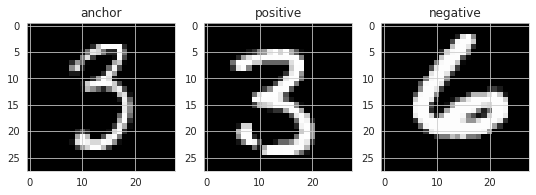

In [182]:
images = [a, p, n]
plot_triplet(images)

## 2.0 Building the Siamese Network

In [183]:
image_width = 28
image_height = 28
image_channel = 1

embed_dim = 128
BATCH_SIZE = 124
LEARNING_RATE = 0.001
EPOCH = 50

saver_path = f"/content/drive/MyDrive/MNIST_ tripless_loss/MNIST_siamese_model/siamese_network_{EPOCH}"

In [184]:
# the main CNN network
def CNN(image , embedding_dim, reuse = None):
    with tf.variable_scope("siamese", reuse=reuse):
        weight_init = tf.glorot_normal_initializer()

        hidden_1 = tf.layers.conv2d(inputs = image, 
                                    filters = 32,
                                    kernel_size = 3,
                                    strides = 1,
                                    kernel_initializer = weight_init,
                                   padding = "SAME")
        hidden_1 = tf.nn.leaky_relu(hidden_1, alpha = 0.2)

        hidden_2 = tf.nn.max_pool(hidden_1,
                                  ksize = 2,
                                  strides = 2,
                                 padding = "VALID")



        hidden_3 = tf.layers.conv2d(inputs = hidden_2, 
                                    filters = 64,
                                    kernel_size = 3,
                                    strides = 1,
                                    kernel_initializer = weight_init,
                                    padding = "SAME")
        hidden_3 = tf.nn.leaky_relu(hidden_3, alpha = 0.2)


        hidden_4 = tf.nn.max_pool(hidden_3,
                                  ksize = 2,
                                  strides = 2,
                                 padding = "VALID")


        hidden_5 = tf.layers.flatten(hidden_4)
        
        hidden_6 = tf.layers.dense(hidden_5, units = 256)
        hidden_6 = tf.nn.leaky_relu(hidden_6, alpha = 0.2)
        
        output_layer = tf.layers.dense(hidden_6, units = embedding_dim)
        out = tf.nn.sigmoid(output_layer)
        
        return out

In [185]:
# siamese network 
def siamese_network(anchor_image, positive_image, negative_image, embedding_dimension):
    
    anchor_latent_vect = CNN(anchor_image ,
                             embedding_dim = embedding_dimension,
                             reuse = None)
    positive_latent_vect = CNN(positive_image ,
                               embedding_dim = embedding_dimension,
                               reuse = True)
    negative_latent_vect = CNN(negative_image ,
                               embedding_dim = embedding_dimension,
                               reuse = True)
    
    return [anchor_latent_vect, positive_latent_vect, negative_latent_vect]

In [186]:
# building the network
tf.reset_default_graph()

x_anchor = tf.placeholder(dtype = tf.float32,
                          shape = [None, image_width, image_height, image_channel])

x_positive = tf.placeholder(dtype = tf.float32,
                          shape = [None, image_width, image_height, image_channel])

x_negative = tf.placeholder(dtype = tf.float32,
                          shape = [None, image_width, image_height, image_channel])

anchor_vect, pos_vect, neg_vect = siamese_network(anchor_image = x_anchor,
                          positive_image = x_positive,
                          negative_image = x_negative,
                          embedding_dimension = embed_dim)

latent_vect = CNN(image = x_anchor,
                  embedding_dim = embed_dim,
                  reuse = True)

## 2.1 Building the Tripless loss function

In [187]:
# defining tripless loss
def tripless_loss(anchor_vect, pos_vect, neg_vect, margin = 0.2):
  d_pos = tf.reduce_sum(tf.square(anchor_vect - pos_vect), 1)
  d_neg = tf.reduce_sum(tf.square(anchor_vect - neg_vect), 1)

  loss = tf.reduce_mean(tf.maximum(0.0, margin + d_pos - d_neg))
  return loss


loss = tripless_loss(anchor_vect, pos_vect, neg_vect, margin = 0.5)

## 2.2 Defining the optimizer

In [188]:
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
train_siamese = optimizer.minimize(loss)

## 3.0 Training the Siamese Network with Triplet loss

In [189]:
init = tf.global_variables_initializer()

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(1 , EPOCH):
        anchor, positive, negative = triplet_generator(data = [x_train, y_train], batch_size = BATCH_SIZE)
        _, TL_loss = sess.run([train_siamese, loss], feed_dict = {
            x_anchor : anchor,
            x_positive : positive,
            x_negative : negative
        })
        print(f"Epoch: {epoch} | Triplet loss : {TL_loss}")
    print("Saving model..")
    saving = saver.save(sess, saver_path)
    print("Model saved.")

Epoch: 1 | Triplet loss : 0.4886977970600128
Epoch: 2 | Triplet loss : 0.45045599341392517
Epoch: 3 | Triplet loss : 0.3231636881828308
Epoch: 4 | Triplet loss : 0.3189466595649719
Epoch: 5 | Triplet loss : 0.34261855483055115
Epoch: 6 | Triplet loss : 0.23756706714630127
Epoch: 7 | Triplet loss : 0.2353704422712326
Epoch: 8 | Triplet loss : 0.16321495175361633
Epoch: 9 | Triplet loss : 0.3594408929347992
Epoch: 10 | Triplet loss : 0.31099098920822144
Epoch: 11 | Triplet loss : 0.2552838921546936
Epoch: 12 | Triplet loss : 0.18521951138973236
Epoch: 13 | Triplet loss : 0.23116418719291687
Epoch: 14 | Triplet loss : 0.25635942816734314
Epoch: 15 | Triplet loss : 0.1984144002199173
Epoch: 16 | Triplet loss : 0.13397985696792603
Epoch: 17 | Triplet loss : 0.15133455395698547
Epoch: 18 | Triplet loss : 0.18502217531204224
Epoch: 19 | Triplet loss : 0.14173702895641327
Epoch: 20 | Triplet loss : 0.1857692003250122
Epoch: 21 | Triplet loss : 0.1540529429912567
Epoch: 22 | Triplet loss : 0.17

## 3.1 Loading the trained model




INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MNIST_ tripless_loss/MNIST_siamese_model/siamese_network_50
Model Loaded.


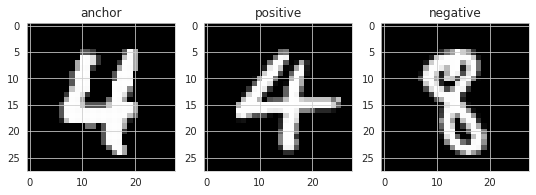



Distance(anchor, positive): 0.51646215
Distance(anchor, negative): 1.3636597


In [190]:
anchor, positive, negative = triplet_generator(data = [x_train, y_train], batch_size = 1)
init = tf.global_variables_initializer()
 
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, saver_path)
    print("Model Loaded.")
    plot_triplet(images = [anchor, positive, negative])
    a_latent, p_latent, n_latent = sess.run([anchor_vect, pos_vect, neg_vect],
                                            feed_dict = {x_anchor : anchor, x_positive : positive, x_negative: negative})    
    print("\n")
    d_pos = np.linalg.norm(a_latent - p_latent)
    d_neg = np.linalg.norm(a_latent - n_latent)

    print("Distance(anchor, positive):", d_pos)
    print("Distance(anchor, negative):", d_neg)

In [191]:
init = tf.global_variables_initializer()
 
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, saver_path)
    print("Model Loaded.")

    latent_vectors = sess.run(latent_vect, feed_dict = {
        x_anchor : mnist.test.images.reshape(10_000, 28, 28, 1)
    })

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MNIST_ tripless_loss/MNIST_siamese_model/siamese_network_50
Model Loaded.


## 3.2 Dimensionality reduction of embedding

In [192]:
def dimensionality_reduction(embeddings = latent_vectors,labels = mnist.test.labels, components = 2, plot = True):
    latent_embed = TSNE(n_components = components).fit_transform(embeddings)
    df = pd.DataFrame(data = {
        f"f{i + 1}" : latent_embed[: , i] for i in range(0,  components)
    })
    df["labels"] = mnist.test.labels

    if plot:
      if components == 2:
        sns.set_style("whitegrid")
        sns.FacetGrid(df,
                    hue= "labels",
                    height=6).map(plt.scatter, "f1", "f2").add_legend()
        plt.show()

      elif components == 3:
        fig = px.scatter_3d(df,
                    x='f1',
                    y='f2',
                    z='f3',
                    color='labels',
                    opacity=1)
        fig.update_traces(marker=dict(size=2),
                          selector=dict(mode='markers'))
        fig.show()

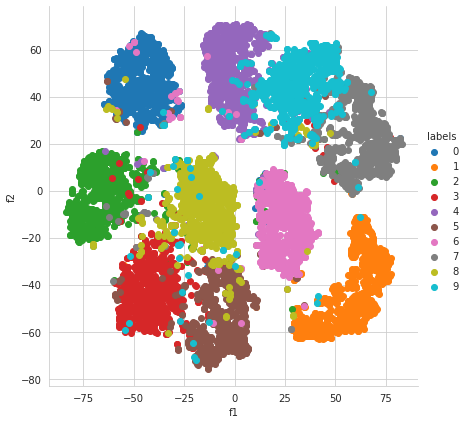

In [199]:
# 2 dimensional representation of the latent vectors using T-sne
dimensionality_reduction(embeddings = latent_vectors,
                         labels = mnist.test.labels,
                         components = 2,
                         plot = True)

In [200]:
# 3 dimensional representation of the latent vectors using T-sne
dimensionality_reduction(embeddings = latent_vectors,
                         labels = mnist.test.labels,
                         components = 3,
                         plot = True)